# Getting data from Global Forecast System - NOAA

In [2]:
import os
import xarray as xr
# import rioxarray
import geopandas as gpd
import numpy as np
import datetime as dt
# from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


%matplotlib inline


Set all the URL to get the data from CFS

In [3]:
res = '0p25'
# date = (dt.date.today() - dt.timedelta(days=1)).strftime("%Y%m%d")
date = (dt.date.today()).strftime("%Y%m%d")

# # this is the daily temperature
# step = '_1hr'
# hour = 6
# gfs = f'https://nomads.ncep.noaa.gov/dods/gfs_{res}{step}'
# url = f'{gfs}/gfs{date}/gfs_{res}{step}_{hour:02d}z'

# this is the forecast
hour = 0
gfs = f'https://nomads.ncep.noaa.gov/dods/gfs_{res}/'
url = f'{gfs}/gfs{date}/gfs_{res}_{hour:02d}z'

print(url)


https://nomads.ncep.noaa.gov/dods/gfs_0p25//gfs20240604/gfs_0p25_00z


Check the URL

In [4]:
print(f'{url}.info')

https://nomads.ncep.noaa.gov/dods/gfs_0p25//gfs20240604/gfs_0p25_00z.info


Set the variable and the bounding box of the data

BBOX Ref = https://gist.github.com/graydon/11198540

BBOX = min Longitude , min Latitude , max Longitude , max Latitude 


In [57]:
# var = 'tmp2m' # temperature at 2m
var = 'apcpsfc' # surface precipitation 

# read bbox from shapefile
_shp = gpd.read_file('D:\\MapAction\\MapAction_GitHub\\cfs-forecast-data\\boundary_data\\blz_admn_ad0_py_s0_gadm_pp_COD_country.shp')
xmin, ymin, xmax, ymax = _shp.total_bounds
# 'MW': ('Malawi', (32.6881653175, -16.8012997372, 35.7719047381, -9.23059905359))
# lat = (53,60)
# lon = (360-11, 360)
lat = (ymin - 0.25,ymax + 0.25)
# lon = (xmin,xmax)
xmin = (xmin - 360) % 360 - 0.25
xmax = (xmax - 360) % 360 + 0.25
lon = (xmin,xmax)

print(lon)
print(lat)


(270.52582549974704, 272.76403045684015)
(15.642658234090277, 18.74728965829115)


Get the data from endpoint

In [58]:
# getting the data as an xarray
with xr.open_dataset(url) as ds:
    ds
    # da = ds[var].isel(time = 0).sel(lat = slice(*lat), lon = slice(*lon))
    da = ds[var].sel(lat = slice(*lat), lon = slice(*lon))  


da
# ds

c:\Users\Luis\anaconda3\envs\ma_geo\lib\site-packages\xarray\coding\times.py:152: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.DataArray 'apcpsfc' (time: 129, lat: 12, lon: 9)>
[13932 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2024-06-04 2024-06-04T03:00:00 ... 2024-06-20
  * lat      (lat) float64 15.75 16.0 16.25 16.5 16.75 ... 17.75 18.0 18.25 18.5
  * lon      (lon) float64 270.8 271.0 271.2 271.5 271.8 272.0 272.2 272.5 272.8
Attributes:
    long_name:  ** surface total precipitation [kg/m^2]

In [59]:
da.to_netcdf('D:\\MapAction\\MapAction_GitHub\\cfs-forecast-data\\forecast_data\\blz_admn_ad0_py_s0_gadm_pp_COD_country.nc')


Work with the downloaded data
- Set everything for the loop to create .tif files

In [60]:
# Resaple Temp values using an average for the day 
# The data is downloaded at 00, 03, 06, 09, 12, 15, 18, 21, 24 time intervals
# da_daily = np.round(da.resample(time='24H').mean('time') - 273.1) # this is for temperature
da_daily = np.round(da.resample(time='24H').sum('time')) # this is for rainfall - 1 kg of rain water spread over 1 square meter of surface is 1 mm in thickness 

# conver xarray to rioxarray - enable the creation of tif files
da_daily.rio.write_crs("epsg:4326", inplace=True)

# rename dimensions to avoid errors with rio
da_daily = da_daily.rename({'lon': 'x','lat': 'y'})


# Create list with the dates - this will be used to create .tif files
lst_dates = da_daily.coords['time'].values

lst_dates
# Open country ADM0 as geopandas
# country = gpd.read_file('D:/MapAction/MapAction_Geospatial/2_CountryResponses/OwnCloud/MapAction/2023-tur-001/GIS/2_Active_Data/202_admn/tur_admn_ad0_py_s0_gcm_pp_country.shp')



array(['2024-06-04T00:00:00.000000000', '2024-06-05T00:00:00.000000000',
       '2024-06-06T00:00:00.000000000', '2024-06-07T00:00:00.000000000',
       '2024-06-08T00:00:00.000000000', '2024-06-09T00:00:00.000000000',
       '2024-06-10T00:00:00.000000000', '2024-06-11T00:00:00.000000000',
       '2024-06-12T00:00:00.000000000', '2024-06-13T00:00:00.000000000',
       '2024-06-14T00:00:00.000000000', '2024-06-15T00:00:00.000000000',
       '2024-06-16T00:00:00.000000000', '2024-06-17T00:00:00.000000000',
       '2024-06-18T00:00:00.000000000', '2024-06-19T00:00:00.000000000',
       '2024-06-20T00:00:00.000000000'], dtype='datetime64[ns]')

- Running the loop for .tif files

In [63]:
# Create tif files with the forecast
# It is one tif file per day
for count, values in enumerate(lst_dates):
    print(f'Doing {np.datetime_as_string(values, unit="D")}')
    
    # select each day separately
    da_tif = da_daily.isel(time=slice(count, count + 1))
    
    da_tif.coords['x'] = (da_tif.coords['x'] + 180) % 360 - 180
    
    ''' This process below work well for QGIS but not for ArcPro
    It needs reviewing
    
    # Clip to admin data
    clipped = da_tif.rio.clip(country.geometry.values, country.crs, drop=True, invert=False)
    
    '''
    
    # # save xarray to .tif file
    forecast = 'precipitation'
    resolution = '0p25'
    da_tif.rio.to_raster(f'D:\\MapAction\\MapAction_GitHub\\cfs-forecast-data\\forecast_data\\{forecast}_gfs_{np.datetime_as_string(values, unit="D")}_{resolution}_{hour:02d}z.tif')
    # da_tif.rio.to_raster(f'D:/NextCloud/country-responses/2023/2023-mwi-002/GIS/2_Active_Data/218_land/data_download_2023_03_18/mwi_land_rain_ras_s0_cfs_pp_surfaceTotalPrecipit{np.datetime_as_string(values, unit="D")}.tif')
    # # optionally, export data to NetCDF to be used in another software, for instance Panoply tur_land_temp_ras_s0_era5_pp_2mTempAs20230213
    # # da.to_netcdf(f'D:/MapAction/MapAction_GitHub/era5_data_download/{var}_{date}_{hour}.nc')
    
# print(f'The rasters have been downloaded successfully')
da_tif


Doing 2024-06-04
Doing 2024-06-05
Doing 2024-06-06
Doing 2024-06-07
Doing 2024-06-08
Doing 2024-06-09
Doing 2024-06-10
Doing 2024-06-11
Doing 2024-06-12
Doing 2024-06-13
Doing 2024-06-14
Doing 2024-06-15
Doing 2024-06-16
Doing 2024-06-17
Doing 2024-06-18
Doing 2024-06-19
Doing 2024-06-20


<xarray.DataArray 'apcpsfc' (time: 1, y: 12, x: 9)>
array([[[231., 259., 277., 195., 137., 150., 103.,  92.,  61.],
        [260., 284., 290., 216., 162., 125.,  93.,  80.,  58.],
        [244., 241., 260., 220., 179., 142., 117.,  92.,  73.],
        [239., 207., 231., 248., 198., 143., 107., 100., 102.],
        [183., 147., 188., 263., 229., 141., 119., 117., 129.],
        [136., 135., 152., 232., 242., 165., 150., 151., 163.],
        [114., 104., 128., 208., 223., 196., 200., 183., 172.],
        [125., 131., 174., 208., 211., 210., 202., 162., 155.],
        [136., 161., 195., 218., 226., 202., 190., 154., 145.],
        [140., 165., 208., 220., 252., 222., 191., 170., 177.],
        [121., 148., 218., 222., 248., 236., 211., 186., 194.],
        [106., 130., 195., 229., 266., 287., 310., 263., 227.]]],
      dtype=float32)
Coordinates:
  * y            (y) float64 15.75 16.0 16.25 16.5 ... 17.75 18.0 18.25 18.5
  * x            (x) float64 -89.25 -89.0 -88.75 -88.5 ... -87.75 -87.5 -87.25
  * time         (time) datetime64[ns] 2024-06-20
    spatial_ref  int32 0
Attributes:
    long_name:  ** surface total precipitation [kg/m^2]

___
___
### THE CODE BELOW WILL SHOW IF THE DATA DOWNLOADED IS FOR THE RIGHT PLACE

c:\Users\MapAction\.conda\envs\ma_geo\lib\site-packages\xarray\coding\times.py:123: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


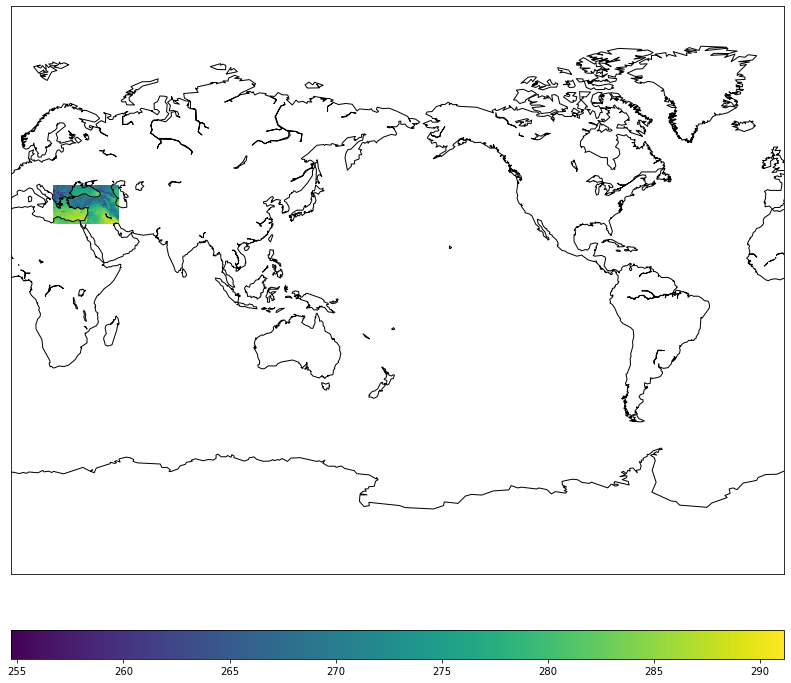

In [21]:
# getting the data as an xarray
with xr.open_dataset(url) as ds:
    da = ds[var].isel(time = 0).sel(lat = slice(*lat), lon = slice(*lon))  
    # this downloads data
    lons = da.lon.data
    lats = da.lat.data
    data = da.data

plt.figure(figsize=(20, 12))
m = Basemap(projection='mill', lon_0=180)

# plot coastlines
m.drawcoastlines()

# map lon-lat to map coordinates
lon2d, lat2d = np.meshgrid(lons, lats)
x, y = m(lon2d, lat2d)

# plot color scale
cs = m.pcolor(x, y, np.squeeze(data))
cbar = m.colorbar(cs, location='bottom', pad="10%")